<a href="https://colab.research.google.com/github/ziishanahmad/ai-web-image-scraper-trainer-model/blob/main/scrapping_image_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
import os
from urllib.parse import urljoin, urlparse
from collections import deque
import pandas as pd

def download_images_from_website(url, output_dir, csv_path, max_depth=3):
    # Load existing CSV data if it exists
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        df = pd.DataFrame(columns=['image_path', 'alt_tag'])

    visited_urls = set()
    queue = deque([(url, 0)])  # Queue of URLs to visit with depth
    new_data = []

    while queue:
        current_url, depth = queue.popleft()

        # Limit crawling depth
        if depth > max_depth:
            continue

        # Ensure unique URLs
        if current_url in visited_urls:
            continue
        visited_urls.add(current_url)

        try:
            response = requests.get(current_url)
            soup = BeautifulSoup(response.text, 'html.parser')

            # Find all image tags
            image_tags = soup.find_all('img')

            for img in image_tags:
                img_url = img.get('src')
                alt_tag = img.get('alt')

                # Skip images without alt tags
                if not alt_tag:
                    continue

                if img_url:
                    # Handle relative URLs
                    img_url = urljoin(current_url, img_url)

                    # Generate a filename based on the image URL
                    img_name = img_url.split('/')[-1]
                    img_path = os.path.join(output_dir, img_name)

                    # Check if image is already downloaded
                    if img_path in df['image_path'].values:
                        print(f"Image already downloaded: {img_path}")
                        continue

                    # Download the image
                    img_response = requests.get(img_url)

                    # Save the image
                    with open(img_path, 'wb') as f:
                        f.write(img_response.content)

                    # Store image path and alt tag
                    new_data.append((img_path, alt_tag))

                    # Print information
                    print(f"Downloaded: {img_path}, Alt Tag: {alt_tag}")

        except Exception as e:
            print(f"Error fetching {current_url}: {e}")

        # Find links to other pages
        if depth < max_depth:
            for link in soup.find_all('a', href=True):
                next_url = urljoin(current_url, link['href'])

                # Ensure the link is within the same domain
                if urlparse(next_url).netloc == urlparse(url).netloc:
                    queue.append((next_url, depth + 1))

        # Append new data to existing DataFrame and save to CSV
        new_df = pd.DataFrame(new_data, columns=['image_path', 'alt_tag'])
        df = pd.concat([df, new_df], ignore_index=True)
        df.to_csv(csv_path, index=False)

        print("Data saved to CSV.")

# Example usage
website_url = 'https://www.apple.com/'
output_parent_directory = '/content/drive/My Drive/datasets/applescrapper1'  # Update with your desired parent directory
csv_file_path = '/content/drive/My Drive/datasets/ddata1.csv'  # Update with your CSV path
max_depth = 3  # Maximum depth level to crawl

if not os.path.exists(output_parent_directory):
    os.makedirs(output_parent_directory)

download_images_from_website(website_url, output_parent_directory, csv_file_path, max_depth)


Exception ignored in: <function _xla_gc_callback at 0x7a6e0e0780d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Data saved to CSV.
Data saved to CSV.
Image already downloaded: /content/drive/My Drive/datasets/applescrapper1/boc_ease_01__fubebwkx80q6_large.jpg
Image already downloaded: /content/drive/My Drive/datasets/applescrapper1/boc_ease_01__fubebwkx80q6_large.jpg
Image already downloaded: /content/drive/My Drive/datasets/applescrapper1/boc_ease_02__5a1r49adu0y6_large.jpg
Image already downloaded: /content/drive/My Drive/datasets/applescrapper1/boc_ease_02__5a1r49adu0y6_large.jpg
Image already downloaded: /content/drive/My Drive/datasets/applescrapper1/mac_performance__dh5hyac1zf8m_xlarge.jpg
Image already downloaded: /content/drive/My Drive/datasets/applescrapper1/mac_performance__dh5hyac1zf8m_xlarge.jpg
Image already downloaded: /content/drive/My Drive/datasets/applescrapper1/boc_performance_01__slniatu7x8yi_large.jpg
Image already downloaded: /content/drive/My Drive/datasets/applescrapper1/boc_performance_01__slniatu7x8yi_large.jpg
Image already downloaded: /content/drive/My Drive/datasets

In [3]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import necessary libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check if GPU is available
if not tf.test.gpu_device_name():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(tf.test.gpu_device_name()))

# Step 3: Load CSV data
csv_file_path = '/content/drive/My Drive/datasets/ddata1.csv'  # Updated CSV path
df = pd.read_csv(csv_file_path)

# Step 4: Data preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    validation_split=0.2  # Split data into 80% training and 20% validation
)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col='image_path',
    y_col='alt_tag',
    target_size=(224, 224),  # Resize images as needed
    batch_size=32,
    class_mode='categorical',  # Adjust class mode as per your labels
    subset='training'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col='image_path',
    y_col='alt_tag',
    target_size=(224, 224),  # Resize images as needed
    batch_size=32,
    class_mode='categorical',  # Adjust class mode as per your labels
    subset='validation'
)

# Step 5: Build and train the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Model architecture (example CNN)
num_classes = len(train_generator.class_indices)  # Number of unique alt tags

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Adjust output units for number of unique alt tags
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history = model.fit(
    train_generator,
    epochs=5,  # Reduced number of epochs
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Evaluate model
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Step 6: Save the trained model
model.save('/content/drive/My Drive/datasets/model.h5')

# Step 7: Predict labels for new images
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image_label(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    class_indices = train_generator.class_indices
    labels = dict((v,k) for k,v in class_indices.items())

    return labels[predicted_class[0]]

# Example usage
new_image_path = '/content/drive/My Drive/datasets/applescrapper1/hero_iphone_pro_max__bsan8nevcgty_large.jpg'  # Update with the path to your new image
predicted_label = predict_image_label(new_image_path, model)
print(f"Predicted Label: {predicted_label}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found GPU at: /device:GPU:0
Found 20537 validated image filenames belonging to 352 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 7378 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 5134 validated image filenames belonging to 352 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 7378 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


642/642 [==============================] - 303s 468ms/step - loss: 0.6546 - accuracy: 0.8795 - val_loss: 0.0221 - val_accuracy: 0.9907
Epoch 2/5
642/642 [==============================] - 295s 460ms/step - loss: 0.0972 - accuracy: 0.9667 - val_loss: 0.0201 - val_accuracy: 0.9907
Epoch 3/5
642/642 [==============================] - 299s 466ms/step - loss: 0.0789 - accuracy: 0.9712 - val_loss: 0.0205 - val_accuracy: 0.9907
Epoch 4/5
642/642 [==============================] - 328s 510ms/step - loss: 0.1149 - accuracy: 0.9642 - val_loss: 0.0178 - val_accuracy: 0.9907
Epoch 5/5
161/161 [==============================] - 62s 382ms/step - loss: 0.0168 - accuracy: 0.9907
Validation Accuracy: 99.07%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 271ms/step
Predicted Label: Rear view of Apple Vision Pro showing the displays


1/1 [==============================] - 0s 40ms/step


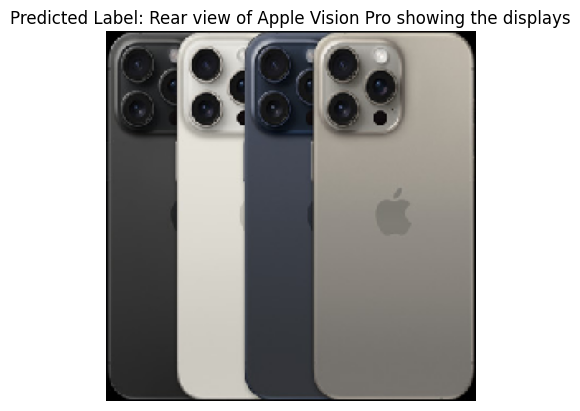

In [9]:
# Step 7: Predict labels for new images
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image_label(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    class_indices = train_generator.class_indices
    labels = dict((v,k) for k,v in class_indices.items())

    return img, labels[predicted_class[0]]

# Example usage
new_image_path = '/content/drive/My Drive/datasets/applescrapper1/hero_iphone_pro_max__bsan8nevcgty_large.jpg'  # Update with the path to your new image
img, predicted_label = predict_image_label(new_image_path, model)

# Convert image to displayable format and show it with predicted label
plt.imshow(img)
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()